# Практическое задание

## 1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [1]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import Input, Conv2DTranspose, BatchNormalization, Dropout, ReLU, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback

from IPython.display import clear_output

In [2]:
# load data
ds_names = 'caltech_birds2010', 'oxford_iiit_pet'

tfds.disable_progress_bar()
dataset, info = tfds.load(ds_names[0], with_info=True)

In [3]:
# additional functions 
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

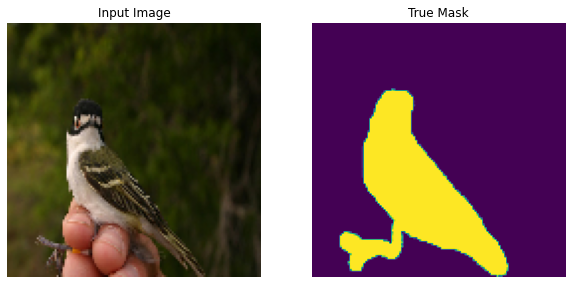

In [5]:
# view data
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [6]:
image_shape = image.shape # 128, 128, 3

base_model = MobileNetV2(
    input_shape=image_shape,
    include_top=False)

In [7]:
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project'      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(
    inputs=base_model.input, 
    outputs=layers)

down_stack.trainable = False

In [8]:
def upsample(filters, size, apply_dropout=False):
  '''https://www.tensorflow.org/tutorials/generative/pix2pix'''

  initializer = tf.random_normal_initializer(0., 0.02)

  conv2d_transpose = Conv2DTranspose(
      filters, size, 
      strides=2, 
      padding='same', 
      kernel_initializer=initializer,
      use_bias=False)

  result = Sequential(
      [conv2d_transpose,
       BatchNormalization()])

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [9]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [10]:
def unet_model(filters: int) -> 'U-Net model':
  
  """ Function for create U-Net model type

  inputs:
    output channels - count pixel labels in int type
  output:
    U-Net type model """

  inputs = Input(shape=image_shape)
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = Concatenate()
    x = concat([x, skip])

  last = Conv2DTranspose(
      filters=filters, 
      kernel_size=3,
      strides=2,
      padding='same')

  x = last(x)

  return Model(inputs=inputs, outputs=x)

In [11]:
# create u-net model
model = unet_model(2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

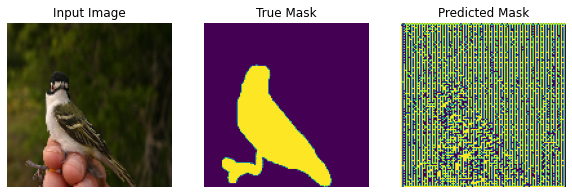

In [13]:
show_predictions()

In [14]:
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print (f'\nSample Prediction after epoch {epoch+1}\n')

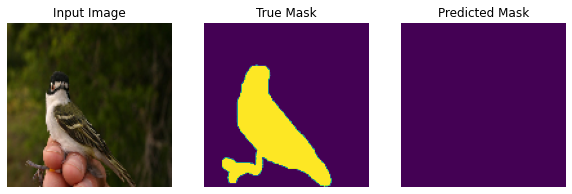


Sample Prediction after epoch 5



In [15]:
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//5

model_history = model.fit(train_dataset, 
                          epochs=5,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

2. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview
3. *Сделайте свою реализацию U-Net на TensorFlow